In [101]:
import tensorflow as tf

import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Bidirectional
from tensorflow.keras.layers import Dense
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.layers import Activation, Dense, Dropout
from tensorflow.keras import optimizers
from pandas import Series
import math
import numpy
from tensorflow.keras.layers import *
from tensorflow.keras import layers
import pandas as pd

import datetime

data = pd.read_csv("SeoulBikeData (1).csv")

In [2]:
def gradient_importance(seq, model):

    seq = tf.Variable(seq[np.newaxis,:,:], dtype=tf.float32)

    with tf.GradientTape() as tape:
        predictions = model(seq)

    grads = tape.gradient(predictions, seq)
    grads = tf.reduce_mean(grads, axis=1).numpy()[0]
    
    return grads

def gradient_weight(seq, model):

    seq = tf.Variable(seq[np.newaxis,:,:], dtype=tf.float32)

    with tf.GradientTape() as tape:
        predictions = model(seq)

    grad = tape.gradient(predictions, seq)
    #gr=grads
    #grads = tf.reduce_mean(grads, axis=1).numpy()[0]
    
    return grad


def activation_grad(seq, model):
    
    seq = seq[np.newaxis,:,:]
    grad_model = Model([model.inputs], 
                       [model.get_layer('extractor').output, 
                        model.output])

    # Obtain the predicted value and the intermediate filters
    with tf.GradientTape() as tape:
        seq_outputs, predictions = grad_model(seq)

    # Extract filters and gradients
    output = seq_outputs[0]
    grads = tape.gradient(predictions, seq_outputs)[0]

    # Average gradients spatially
    weights = tf.reduce_mean(grads, axis=0)
    
    # Get a ponderated map of filters according to grad importance
    cam = np.ones(output.shape[0], dtype=np.float32)
    for index, w in enumerate(weights):
        cam += w * output[:, index]

    time = int(seq.shape[1]/output.shape[0])
    cam = zoom(cam.numpy(), time, order=1)
    heatmap = (cam - cam.min())/(cam.max() - cam.min())
    
    return heatmap

In [3]:
import numpy as np

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [4]:
cols=data.columns[1:-3]
cols

Index(['Rented Bike Count', 'Hour', 'Temperature', 'Humidity(%)',
       'Wind speed (m/s)', 'Visibility (10m)', 'Dew point temperature',
       'Solar Radiation (MJ/m2)', 'Rainfall(mm)', 'Snowfall (cm)'],
      dtype='object')

In [5]:
cols=data.columns[1:-3]
cols=cols.drop(['Hour'])

In [6]:
cols

Index(['Rented Bike Count', 'Temperature', 'Humidity(%)', 'Wind speed (m/s)',
       'Visibility (10m)', 'Dew point temperature', 'Solar Radiation (MJ/m2)',
       'Rainfall(mm)', 'Snowfall (cm)'],
      dtype='object')

In [7]:
date_time = pd.to_datetime(data.pop('Date'), format='%d/%m/%Y')

In [8]:
SMALL_SIZE = 20
MEDIUM_SIZE = 23
BIGGER_SIZE = 25

plt.rc('font', size=SMALL_SIZE) # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE) # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE) # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE) # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE) # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE) # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE) # fontsize of the figure title

Index(['Rented Bike Count', 'Temperature', 'Humidity(%)', 'Wind speed (m/s)',
       'Visibility (10m)', 'Dew point temperature', 'Solar Radiation (MJ/m2)',
       'Rainfall(mm)', 'Snowfall (cm)'],
      dtype='object')
      Rented Bike Count  Hour  Temperature  Humidity(%)  Wind speed (m/s)  \
0                   254     0         -5.2           37               2.2   
1                   204     1         -5.5           38               0.8   
2                   173     2         -6.0           39               1.0   
3                   107     3         -6.2           40               0.9   
4                    78     4         -6.0           36               2.3   
...                 ...   ...          ...          ...               ...   
8755               1003    19          4.2           34               2.6   
8756                764    20          3.4           37               2.3   
8757                694    21          2.6           39               0.3   
8758      

<Figure size 1440x1080 with 0 Axes>

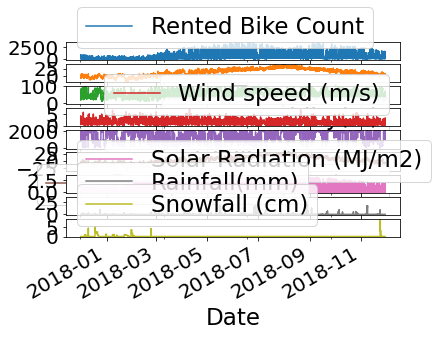

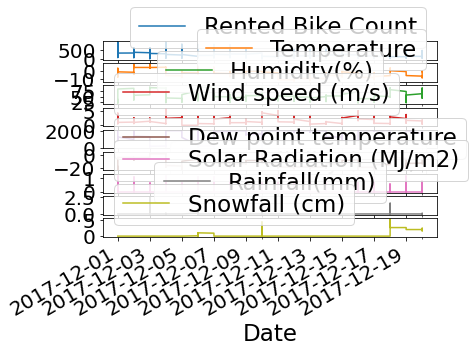

In [9]:
plt.figure(figsize=(20,15))

plot_cols = cols
df=data
print(cols)
print(data)

plot_features = df[plot_cols]
plot_features.index = date_time
_ = plot_features.plot(subplots=True)

plot_features = df[plot_cols][:480]
plot_features.index = date_time[:480]
_ = plot_features.plot(subplots=True)

In [10]:
from sklearn.preprocessing import MinMaxScaler
values = data[cols].values.reshape(-1,9)
values = values.astype('float32')
#scaler = MinMaxScaler(feature_range=(0, 1))
scaled = (values-(np.min(values)))/(np.max(values)-(np.min(values)))
#scaled = (values - np.mean(values))/np.std(values)
#scaled=scaler.fit_transform(values)

In [11]:
def fill_missing(values):
    one_day = 7 * 24
    for row in range(values.shape[0]):
        for col in range(values.shape[1]):
            if values[row,0]==0:
                values[row,0] = values[row - one_day,0]

In [12]:
fill_missing(values)

In [13]:
train_size = int(len(scaled) * 0.80)
val_size = int(len(scaled) * 0.10)

test_size = len(scaled) - train_size-val_size
train,val, test = scaled[0:train_size,:],scaled[train_size:train_size+val_size,:], scaled[train_size+val_size:,:]
print(len(train),len(val), len(test))

7008 876 876


In [14]:
def create_dataset_mul(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i + look_back)]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    print(len(dataY))
    return np.array(dataX), np.array(dataY)

In [15]:
look_back = 24
trainX, trainY = create_dataset_mul(train, look_back)
valX, valY = create_dataset_mul(val, look_back)
testX, testY = create_dataset_mul(test, look_back)

6984
852
852


In [16]:
trainX.shape

(6984, 24, 9)

## MTEX(1)

In [17]:
trainX = trainX.reshape(-1,24,9,1)
testX = testX.reshape(-1,24,9,1)
valX = valX.reshape(-1,24,9,1)

In [18]:
first_input = Input(shape=(24,9,1))

in0=Conv2D(filters=16, kernel_size=(24//3,1),input_shape=(24,9,1), activation='relu',padding='same')(first_input)
#in1= BatchNormalization(scale=False)(in1)

in1=Conv2D(filters=32, kernel_size=(24//5,1), activation='relu',padding='same')(in0)
#in0= BatchNormalization(scale=False)(in0)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)

in1=Conv2D(filters=1, kernel_size=1, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in1)
print(in1.shape)
in1 = Reshape((24,9))(in1)
in0=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in1)

#in1=Conv1D(filters=64, kernel_size=2, activation='relu',padding='same')(in0)
#in0= BatchNormalization(scale=False)(in0)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)

#in1=Conv1D(filters=64, kernel_size=1, activation='relu',padding='same',name='extractor')(in1)
#in1=add([in0,in1],name='extractor')
#attn_layer = AttentionLayer(name='attention_layer')
#attn_out, attn_states = attn_layer([in1,in1])

    # Concat attention input and LSTM output, in original code it was decoder LSTM
#concat_out = Concatenate(axis=-1, name='concat_layer')([in1, attn_out])
#in1=MaxPooling1D(pool_size=2,name='extractor')(in1)

#in1=add([in0,in1])
in1=Flatten()(in0)
#in1=Dense(50, activation='relu')(in1)
#in1=LSTM(64)(in1)
in1 = Dense(32,activation='relu')(in1)

out=Dense(1)(in1)
model=tf.keras.Model(inputs=[first_input],outputs=[out])
model.compile(optimizer='adam', loss='mse')


checkpoint_path = "saved_weights/bike_MTEX_onestep(1).hdf5"
cb = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_best_only=True,
                                        monitor='val_loss',mode='min',
                                                 verbose=1)
model.summary()
# fit model9
# history=model.fit(trainX, trainY, epochs=200, batch_size=100, validation_data=(valX, valY), verbose=1, callbacks=[cb])

2022-06-20 17:01:55.063231: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-06-20 17:01:55.126110: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


(None, 24, 9, 1)
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 24, 9, 1)]        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 24, 9, 16)         144       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 9, 32)         2080      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 9, 1)          33        
_________________________________________________________________
reshape (Reshape)            (None, 24, 9)             0         
_________________________________________________________________
conv1d (Conv1D)              (None, 24, 64)            1792      
_________________________________________________________________
flatten (Flatten)            (None, 1536)   

70/70 [==============================] - 0s 6ms/step - loss: 9.4988e-04 - val_loss: 0.0024

Epoch 00039: val_loss did not improve from 0.00240
Epoch 40/200
70/70 [==============================] - 0s 6ms/step - loss: 9.7935e-04 - val_loss: 0.0025

Epoch 00040: val_loss did not improve from 0.00240
Epoch 41/200
70/70 [==============================] - 0s 6ms/step - loss: 9.8291e-04 - val_loss: 0.0024

Epoch 00041: val_loss improved from 0.00240 to 0.00239, saving model to saved_weights/bike_MTEX_onestep(1).hdf5
Epoch 42/200
70/70 [==============================] - 0s 6ms/step - loss: 9.6315e-04 - val_loss: 0.0024

Epoch 00042: val_loss improved from 0.00239 to 0.00237, saving model to saved_weights/bike_MTEX_onestep(1).hdf5
Epoch 43/200
70/70 [==============================] - 0s 6ms/step - loss: 9.4947e-04 - val_loss: 0.0024

Epoch 00043: val_loss did not improve from 0.00237
Epoch 44/200
70/70 [==============================] - 0s 6ms/step - loss: 9.0589e-04 - val_loss: 0.0024

Epoch 


Epoch 00089: val_loss did not improve from 0.00224
Epoch 90/200
70/70 [==============================] - 0s 6ms/step - loss: 5.9393e-04 - val_loss: 0.0024

Epoch 00090: val_loss did not improve from 0.00224
Epoch 91/200
70/70 [==============================] - 0s 6ms/step - loss: 5.9599e-04 - val_loss: 0.0023

Epoch 00091: val_loss did not improve from 0.00224
Epoch 92/200
70/70 [==============================] - 0s 6ms/step - loss: 5.6109e-04 - val_loss: 0.0023

Epoch 00092: val_loss did not improve from 0.00224
Epoch 93/200
70/70 [==============================] - 0s 6ms/step - loss: 6.0144e-04 - val_loss: 0.0023

Epoch 00093: val_loss did not improve from 0.00224
Epoch 94/200
70/70 [==============================] - 0s 6ms/step - loss: 5.5868e-04 - val_loss: 0.0024

Epoch 00094: val_loss did not improve from 0.00224
Epoch 95/200
70/70 [==============================] - 0s 6ms/step - loss: 6.0079e-04 - val_loss: 0.0023

Epoch 00095: val_loss did not improve from 0.00224
Epoch 96/200

70/70 [==============================] - 0s 6ms/step - loss: 3.9048e-04 - val_loss: 0.0025

Epoch 00142: val_loss did not improve from 0.00224
Epoch 143/200
70/70 [==============================] - 0s 6ms/step - loss: 3.5391e-04 - val_loss: 0.0026

Epoch 00143: val_loss did not improve from 0.00224
Epoch 144/200
70/70 [==============================] - 0s 6ms/step - loss: 3.8834e-04 - val_loss: 0.0028

Epoch 00144: val_loss did not improve from 0.00224
Epoch 145/200
70/70 [==============================] - 0s 6ms/step - loss: 3.7121e-04 - val_loss: 0.0026

Epoch 00145: val_loss did not improve from 0.00224
Epoch 146/200
70/70 [==============================] - 0s 6ms/step - loss: 3.3195e-04 - val_loss: 0.0026

Epoch 00146: val_loss did not improve from 0.00224
Epoch 147/200
70/70 [==============================] - 0s 6ms/step - loss: 4.0158e-04 - val_loss: 0.0025

Epoch 00147: val_loss did not improve from 0.00224
Epoch 148/200
70/70 [==============================] - 0s 6ms/step - los

In [22]:
model.load_weights("saved_weights/bike_MTEX_onestep(1).hdf5")

In [23]:
from sklearn.metrics import mean_absolute_error

In [24]:
def mean_absolute_percentage_error(Y_actual,Y_Predicted):
    mape = np.mean(np.abs((Y_actual - Y_Predicted)/Y_actual))*100
    return mape

In [25]:
from sklearn.metrics import *
from math import *
predict = model.predict(testX)
test_rmse = sqrt(mean_squared_error(testY, predict))
predicted = model.predict(testX)
test_mae = mean_absolute_error(testY, predicted)
test_mse = mean_squared_error(testY, predicted)
mape=mean_absolute_percentage_error(testY, predicted)
print('Test MAPE: ', mape)
print('Test RMSE :', test_rmse)
print('Test MAE :', test_mae)
print('Test MSE :', test_mse)

Test MAPE:  0.31142873
Test RMSE : 0.0360448158828967
Test MAE : 0.024172617
Test MSE : 0.0012992288


## MTEX(2)

In [53]:
first_input = Input(shape=(24,9,1))

in0=Conv2D(filters=16, kernel_size=(24//3,1),input_shape=(24,9,1), activation='relu',padding='same')(first_input)
#in1= BatchNormalization(scale=False)(in1)

in1=Conv2D(filters=32, kernel_size=(24//5,1), activation='relu',padding='same')(in0)
#in0= BatchNormalization(scale=False)(in0)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)

in1=Conv2D(filters=1, kernel_size=1, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in1)
print(in1.shape)
in1 = Reshape((24,9))(in1)
in0=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in1)

#in1=Conv1D(filters=64, kernel_size=2, activation='relu',padding='same')(in0)
#in0= BatchNormalization(scale=False)(in0)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)

#in1=Conv1D(filters=64, kernel_size=1, activation='relu',padding='same',name='extractor')(in1)
#in1=add([in0,in1],name='extractor')
#attn_layer = AttentionLayer(name='attention_layer')
#attn_out, attn_states = attn_layer([in1,in1])

    # Concat attention input and LSTM output, in original code it was decoder LSTM
#concat_out = Concatenate(axis=-1, name='concat_layer')([in1, attn_out])
#in1=MaxPooling1D(pool_size=2,name='extractor')(in1)

#in1=add([in0,in1])
in1=Flatten()(in0)
#in1=Dense(50, activation='relu')(in1)
#in1=LSTM(64)(in1)
in1 = Dense(32,activation='relu')(in1)

out=Dense(1)(in1)
model=tf.keras.Model(inputs=[first_input],outputs=[out])
model.compile(optimizer='adam', loss='mse')


checkpoint_path = "saved_weights/bike_MTEX_onestep(2).hdf5"
cb = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_best_only=True,
                                        monitor='val_loss',mode='min',
                                                 verbose=1)
model.summary()
# fit model9
# history=model.fit(trainX, trainY, epochs=200, batch_size=100, validation_data=(valX, valY), verbose=1, callbacks=[cb])

(None, 24, 9, 1)
Model: "model_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, 24, 9, 1)]        0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 24, 9, 16)         144       
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 24, 9, 32)         2080      
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 24, 9, 1)          33        
_________________________________________________________________
reshape_10 (Reshape)         (None, 24, 9)             0         
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 24, 64)            1792      
_________________________________________________________________
flatten_10 (Flatten)         (None, 1536)

Epoch 39/200
70/70 [==============================] - 0s 6ms/step - loss: 9.9891e-04 - val_loss: 0.0023

Epoch 00039: val_loss did not improve from 0.00232
Epoch 40/200
70/70 [==============================] - 0s 6ms/step - loss: 9.2829e-04 - val_loss: 0.0024

Epoch 00040: val_loss did not improve from 0.00232
Epoch 41/200
70/70 [==============================] - 0s 6ms/step - loss: 9.8570e-04 - val_loss: 0.0024

Epoch 00041: val_loss did not improve from 0.00232
Epoch 42/200
70/70 [==============================] - 0s 6ms/step - loss: 9.3587e-04 - val_loss: 0.0024

Epoch 00042: val_loss did not improve from 0.00232
Epoch 43/200
70/70 [==============================] - 0s 6ms/step - loss: 9.2838e-04 - val_loss: 0.0024

Epoch 00043: val_loss did not improve from 0.00232
Epoch 44/200
70/70 [==============================] - 0s 6ms/step - loss: 9.2251e-04 - val_loss: 0.0024

Epoch 00044: val_loss did not improve from 0.00232
Epoch 45/200
70/70 [==============================] - 0s 6ms/ste

70/70 [==============================] - 0s 6ms/step - loss: 3.8889e-04 - val_loss: 0.0025

Epoch 00142: val_loss did not improve from 0.00220
Epoch 143/200
70/70 [==============================] - 0s 6ms/step - loss: 3.7849e-04 - val_loss: 0.0026

Epoch 00143: val_loss did not improve from 0.00220
Epoch 144/200
70/70 [==============================] - 0s 6ms/step - loss: 3.8780e-04 - val_loss: 0.0026

Epoch 00144: val_loss did not improve from 0.00220
Epoch 145/200
70/70 [==============================] - 0s 6ms/step - loss: 3.8856e-04 - val_loss: 0.0026

Epoch 00145: val_loss did not improve from 0.00220
Epoch 146/200
70/70 [==============================] - 0s 6ms/step - loss: 3.8289e-04 - val_loss: 0.0025

Epoch 00146: val_loss did not improve from 0.00220
Epoch 147/200
70/70 [==============================] - 0s 6ms/step - loss: 3.7088e-04 - val_loss: 0.0026

Epoch 00147: val_loss did not improve from 0.00220
Epoch 148/200
70/70 [==============================] - 0s 6ms/step - los

In [54]:
model.load_weights("saved_weights/bike_MTEX_onestep(2).hdf5")

In [55]:
from sklearn.metrics import *
from math import *
predict = model.predict(testX)
test_rmse = sqrt(mean_squared_error(testY, predict))
predicted = model.predict(testX)
test_mae = mean_absolute_error(testY, predicted)
test_mse = mean_squared_error(testY, predicted)
mape=mean_absolute_percentage_error(testY, predicted)
print('Test MAPE: ', mape)
print('Test RMSE :', test_rmse)
print('Test MAE :', test_mae)
print('Test MSE :', test_mse)

Test MAPE:  0.3078137
Test RMSE : 0.035684351038713875
Test MAE : 0.02355713
Test MSE : 0.0012733729


## MTEX(3)

In [98]:
first_input = Input(shape=(24,9,1))

in0=Conv2D(filters=16, kernel_size=(24//3,1),input_shape=(24,9,1), activation='relu',padding='same')(first_input)
#in1= BatchNormalization(scale=False)(in1)

in1=Conv2D(filters=32, kernel_size=(24//5,1), activation='relu',padding='same')(in0)
#in0= BatchNormalization(scale=False)(in0)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)

in1=Conv2D(filters=1, kernel_size=1, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in1)
print(in1.shape)
in1 = Reshape((24,9))(in1)
in0=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in1)

#in1=Conv1D(filters=64, kernel_size=2, activation='relu',padding='same')(in0)
#in0= BatchNormalization(scale=False)(in0)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)

#in1=Conv1D(filters=64, kernel_size=1, activation='relu',padding='same',name='extractor')(in1)
#in1=add([in0,in1],name='extractor')
#attn_layer = AttentionLayer(name='attention_layer')
#attn_out, attn_states = attn_layer([in1,in1])

    # Concat attention input and LSTM output, in original code it was decoder LSTM
#concat_out = Concatenate(axis=-1, name='concat_layer')([in1, attn_out])
#in1=MaxPooling1D(pool_size=2,name='extractor')(in1)

#in1=add([in0,in1])
in1=Flatten()(in0)
#in1=Dense(50, activation='relu')(in1)
#in1=LSTM(64)(in1)
in1 = Dense(32,activation='relu')(in1)

out=Dense(1)(in1)
model=tf.keras.Model(inputs=[first_input],outputs=[out])
model.compile(optimizer='adam', loss='mse')


checkpoint_path = "saved_weights/bike_MTEX_onestep(3).hdf5"
cb = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_best_only=True,
                                        monitor='val_loss',mode='min',
                                                 verbose=1)
model.summary()
# fit model9
# history=model.fit(trainX, trainY, epochs=200, batch_size=100, validation_data=(valX, valY), verbose=1, callbacks=[cb])

(None, 24, 9, 1)
Model: "model_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_26 (InputLayer)        [(None, 24, 9, 1)]        0         
_________________________________________________________________
conv2d_75 (Conv2D)           (None, 24, 9, 16)         144       
_________________________________________________________________
conv2d_76 (Conv2D)           (None, 24, 9, 32)         2080      
_________________________________________________________________
conv2d_77 (Conv2D)           (None, 24, 9, 1)          33        
_________________________________________________________________
reshape_25 (Reshape)         (None, 24, 9)             0         
_________________________________________________________________
conv1d_25 (Conv1D)           (None, 24, 64)            1792      
_________________________________________________________________
flatten_25 (Flatten)         (None, 1536)

70/70 [==============================] - 1s 9ms/step - loss: 0.0011 - val_loss: 0.0024

Epoch 00038: val_loss did not improve from 0.00223
Epoch 39/200
70/70 [==============================] - 1s 9ms/step - loss: 0.0010 - val_loss: 0.0026

Epoch 00039: val_loss did not improve from 0.00223
Epoch 40/200
70/70 [==============================] - 1s 9ms/step - loss: 0.0011 - val_loss: 0.0023

Epoch 00040: val_loss did not improve from 0.00223
Epoch 41/200
70/70 [==============================] - 1s 9ms/step - loss: 0.0010 - val_loss: 0.0023

Epoch 00041: val_loss did not improve from 0.00223
Epoch 42/200
70/70 [==============================] - 1s 8ms/step - loss: 9.5802e-04 - val_loss: 0.0024

Epoch 00042: val_loss did not improve from 0.00223
Epoch 43/200
70/70 [==============================] - 1s 9ms/step - loss: 0.0010 - val_loss: 0.0023

Epoch 00043: val_loss did not improve from 0.00223
Epoch 44/200
70/70 [==============================] - 1s 9ms/step - loss: 9.7985e-04 - val_loss: 


Epoch 00140: val_loss did not improve from 0.00207
Epoch 141/200
70/70 [==============================] - 1s 9ms/step - loss: 4.5077e-04 - val_loss: 0.0022

Epoch 00141: val_loss did not improve from 0.00207
Epoch 142/200
70/70 [==============================] - 1s 9ms/step - loss: 4.7005e-04 - val_loss: 0.0022

Epoch 00142: val_loss did not improve from 0.00207
Epoch 143/200
70/70 [==============================] - 1s 9ms/step - loss: 4.5593e-04 - val_loss: 0.0024

Epoch 00143: val_loss did not improve from 0.00207
Epoch 144/200
70/70 [==============================] - 1s 10ms/step - loss: 4.6077e-04 - val_loss: 0.0023

Epoch 00144: val_loss did not improve from 0.00207
Epoch 145/200
70/70 [==============================] - 1s 9ms/step - loss: 3.9799e-04 - val_loss: 0.0024

Epoch 00145: val_loss did not improve from 0.00207
Epoch 146/200
70/70 [==============================] - 1s 9ms/step - loss: 3.9663e-04 - val_loss: 0.0024

Epoch 00146: val_loss did not improve from 0.00207
Epoch

70/70 [==============================] - 1s 9ms/step - loss: 2.8785e-04 - val_loss: 0.0026

Epoch 00193: val_loss did not improve from 0.00207
Epoch 194/200
70/70 [==============================] - 1s 9ms/step - loss: 2.8944e-04 - val_loss: 0.0025

Epoch 00194: val_loss did not improve from 0.00207
Epoch 195/200
70/70 [==============================] - 1s 9ms/step - loss: 2.8647e-04 - val_loss: 0.0023

Epoch 00195: val_loss did not improve from 0.00207
Epoch 196/200
70/70 [==============================] - 1s 10ms/step - loss: 2.9739e-04 - val_loss: 0.0025

Epoch 00196: val_loss did not improve from 0.00207
Epoch 197/200
70/70 [==============================] - 1s 9ms/step - loss: 2.6993e-04 - val_loss: 0.0025

Epoch 00197: val_loss did not improve from 0.00207
Epoch 198/200
70/70 [==============================] - 1s 9ms/step - loss: 2.7426e-04 - val_loss: 0.0025

Epoch 00198: val_loss did not improve from 0.00207
Epoch 199/200
70/70 [==============================] - 1s 9ms/step - lo

In [99]:
model.load_weights("saved_weights/bike_MTEX_onestep(3).hdf5")

In [100]:
from sklearn.metrics import *
from math import *
predict = model.predict(testX)
test_rmse = sqrt(mean_squared_error(testY, predict))
predicted = model.predict(testX)
test_mae = mean_absolute_error(testY, predicted)
test_mse = mean_squared_error(testY, predicted)
mape=mean_absolute_percentage_error(testY, predicted)
print('Test MAPE: ', mape)
print('Test RMSE :', test_rmse)
print('Test MAE :', test_mae)
print('Test MSE :', test_mse)

Test MAPE:  0.30657864
Test RMSE : 0.03449897139940519
Test MAE : 0.022401387
Test MSE : 0.001190179


## MTEX(4)

In [32]:
first_input = Input(shape=(24,9,1))

in0=Conv2D(filters=16, kernel_size=(24//3,1),input_shape=(24,9,1), activation='relu',padding='same')(first_input)
#in1= BatchNormalization(scale=False)(in1)

in1=Conv2D(filters=32, kernel_size=(24//5,1), activation='relu',padding='same')(in0)
#in0= BatchNormalization(scale=False)(in0)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)

in1=Conv2D(filters=1, kernel_size=1, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in1)
print(in1.shape)
in1 = Reshape((24,9))(in1)
in0=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in1)

#in1=Conv1D(filters=64, kernel_size=2, activation='relu',padding='same')(in0)
#in0= BatchNormalization(scale=False)(in0)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)

#in1=Conv1D(filters=64, kernel_size=1, activation='relu',padding='same',name='extractor')(in1)
#in1=add([in0,in1],name='extractor')
#attn_layer = AttentionLayer(name='attention_layer')
#attn_out, attn_states = attn_layer([in1,in1])

    # Concat attention input and LSTM output, in original code it was decoder LSTM
#concat_out = Concatenate(axis=-1, name='concat_layer')([in1, attn_out])
#in1=MaxPooling1D(pool_size=2,name='extractor')(in1)

#in1=add([in0,in1])
in1=Flatten()(in0)
#in1=Dense(50, activation='relu')(in1)
#in1=LSTM(64)(in1)
in1 = Dense(32,activation='relu')(in1)

out=Dense(1)(in1)
model=tf.keras.Model(inputs=[first_input],outputs=[out])
model.compile(optimizer='adam', loss='mse')


checkpoint_path = "saved_weights/bike_MTEX_onestep(4).hdf5"
cb = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_best_only=True,
                                        monitor='val_loss',mode='min',
                                                 verbose=1)
model.summary()
# fit model9
# history=model.fit(trainX, trainY, epochs=200, batch_size=100, validation_data=(valX, valY), verbose=1, callbacks=[cb])

(None, 24, 9, 1)
Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 24, 9, 1)]        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 24, 9, 16)         144       
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 24, 9, 32)         2080      
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 24, 9, 1)          33        
_________________________________________________________________
reshape_3 (Reshape)          (None, 24, 9)             0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 24, 64)            1792      
_________________________________________________________________
flatten_3 (Flatten)          (None, 1536) 

70/70 [==============================] - 0s 5ms/step - loss: 9.9685e-04 - val_loss: 0.0024

Epoch 00038: val_loss did not improve from 0.00238
Epoch 39/200
70/70 [==============================] - 0s 5ms/step - loss: 9.9514e-04 - val_loss: 0.0024

Epoch 00039: val_loss improved from 0.00238 to 0.00238, saving model to saved_weights/bike_MTEX_onestep(4).hdf5
Epoch 40/200
70/70 [==============================] - 0s 5ms/step - loss: 9.8537e-04 - val_loss: 0.0023

Epoch 00040: val_loss improved from 0.00238 to 0.00231, saving model to saved_weights/bike_MTEX_onestep(4).hdf5
Epoch 41/200
70/70 [==============================] - 0s 5ms/step - loss: 9.6241e-04 - val_loss: 0.0023

Epoch 00041: val_loss did not improve from 0.00231
Epoch 42/200
70/70 [==============================] - 0s 6ms/step - loss: 9.6937e-04 - val_loss: 0.0023

Epoch 00042: val_loss improved from 0.00231 to 0.00226, saving model to saved_weights/bike_MTEX_onestep(4).hdf5
Epoch 43/200
70/70 [==============================

70/70 [==============================] - 0s 6ms/step - loss: 4.2889e-04 - val_loss: 0.0024

Epoch 00139: val_loss did not improve from 0.00209
Epoch 140/200
70/70 [==============================] - 0s 6ms/step - loss: 4.5488e-04 - val_loss: 0.0023

Epoch 00140: val_loss did not improve from 0.00209
Epoch 141/200
70/70 [==============================] - 0s 6ms/step - loss: 4.2433e-04 - val_loss: 0.0022

Epoch 00141: val_loss did not improve from 0.00209
Epoch 142/200
70/70 [==============================] - 0s 6ms/step - loss: 4.1278e-04 - val_loss: 0.0023

Epoch 00142: val_loss did not improve from 0.00209
Epoch 143/200
70/70 [==============================] - 0s 6ms/step - loss: 4.0569e-04 - val_loss: 0.0022

Epoch 00143: val_loss did not improve from 0.00209
Epoch 144/200
70/70 [==============================] - 0s 6ms/step - loss: 3.9028e-04 - val_loss: 0.0023

Epoch 00144: val_loss did not improve from 0.00209
Epoch 145/200
70/70 [==============================] - 0s 6ms/step - los

In [33]:
model.load_weights("saved_weights/bike_MTEX_onestep(4).hdf5")

In [34]:
from sklearn.metrics import *
from math import *
predict = model.predict(testX)
test_rmse = sqrt(mean_squared_error(testY, predict))
predicted = model.predict(testX)
test_mae = mean_absolute_error(testY, predicted)
test_mse = mean_squared_error(testY, predicted)
mape=mean_absolute_percentage_error(testY, predicted)
print('Test MAPE: ', mape)
print('Test RMSE :', test_rmse)
print('Test MAE :', test_mae)
print('Test MSE :', test_mse)

Test MAPE:  0.3569243
Test RMSE : 0.03696996294893183
Test MAE : 0.024198962
Test MSE : 0.0013667782


## MTEX(5)

In [59]:
first_input = Input(shape=(24,9,1))

in0=Conv2D(filters=16, kernel_size=(24//3,1),input_shape=(24,9,1), activation='relu',padding='same')(first_input)
#in1= BatchNormalization(scale=False)(in1)

in1=Conv2D(filters=32, kernel_size=(24//5,1), activation='relu',padding='same')(in0)
#in0= BatchNormalization(scale=False)(in0)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)

in1=Conv2D(filters=1, kernel_size=1, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in1)
print(in1.shape)
in1 = Reshape((24,9))(in1)
in0=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in1)

#in1=Conv1D(filters=64, kernel_size=2, activation='relu',padding='same')(in0)
#in0= BatchNormalization(scale=False)(in0)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)

#in1=Conv1D(filters=64, kernel_size=1, activation='relu',padding='same',name='extractor')(in1)
#in1=add([in0,in1],name='extractor')
#attn_layer = AttentionLayer(name='attention_layer')
#attn_out, attn_states = attn_layer([in1,in1])

    # Concat attention input and LSTM output, in original code it was decoder LSTM
#concat_out = Concatenate(axis=-1, name='concat_layer')([in1, attn_out])
#in1=MaxPooling1D(pool_size=2,name='extractor')(in1)

#in1=add([in0,in1])
in1=Flatten()(in0)
#in1=Dense(50, activation='relu')(in1)
#in1=LSTM(64)(in1)
in1 = Dense(32,activation='relu')(in1)

out=Dense(1)(in1)
model=tf.keras.Model(inputs=[first_input],outputs=[out])
model.compile(optimizer='adam', loss='mse')


checkpoint_path = "saved_weights/bike_MTEX_onestep(5).hdf5"
cb = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_best_only=True,
                                        monitor='val_loss',mode='min',
                                                 verbose=1)
model.summary()
# fit model9
# history=model.fit(trainX, trainY, epochs=200, batch_size=100, validation_data=(valX, valY), verbose=1, callbacks=[cb])

(None, 24, 9, 1)
Model: "model_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        [(None, 24, 9, 1)]        0         
_________________________________________________________________
conv2d_36 (Conv2D)           (None, 24, 9, 16)         144       
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 24, 9, 32)         2080      
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 24, 9, 1)          33        
_________________________________________________________________
reshape_12 (Reshape)         (None, 24, 9)             0         
_________________________________________________________________
conv1d_12 (Conv1D)           (None, 24, 64)            1792      
_________________________________________________________________
flatten_12 (Flatten)         (None, 1536)

Epoch 38/200
70/70 [==============================] - 1s 10ms/step - loss: 9.8680e-04 - val_loss: 0.0023

Epoch 00038: val_loss did not improve from 0.00212
Epoch 39/200
70/70 [==============================] - 1s 9ms/step - loss: 9.4812e-04 - val_loss: 0.0022

Epoch 00039: val_loss did not improve from 0.00212
Epoch 40/200
70/70 [==============================] - 1s 10ms/step - loss: 9.4032e-04 - val_loss: 0.0022

Epoch 00040: val_loss did not improve from 0.00212
Epoch 41/200
70/70 [==============================] - 1s 9ms/step - loss: 0.0010 - val_loss: 0.0022

Epoch 00041: val_loss did not improve from 0.00212
Epoch 42/200
70/70 [==============================] - 1s 10ms/step - loss: 9.3817e-04 - val_loss: 0.0022

Epoch 00042: val_loss did not improve from 0.00212
Epoch 43/200
70/70 [==============================] - 1s 9ms/step - loss: 8.8193e-04 - val_loss: 0.0022

Epoch 00043: val_loss did not improve from 0.00212
Epoch 44/200
70/70 [==============================] - 1s 9ms/step


Epoch 00089: val_loss did not improve from 0.00199
Epoch 90/200
70/70 [==============================] - 1s 11ms/step - loss: 6.4596e-04 - val_loss: 0.0021

Epoch 00090: val_loss did not improve from 0.00199
Epoch 91/200
70/70 [==============================] - 1s 10ms/step - loss: 6.2598e-04 - val_loss: 0.0021

Epoch 00091: val_loss did not improve from 0.00199
Epoch 92/200
70/70 [==============================] - 1s 9ms/step - loss: 6.1109e-04 - val_loss: 0.0021

Epoch 00092: val_loss did not improve from 0.00199
Epoch 93/200
70/70 [==============================] - 1s 10ms/step - loss: 6.0061e-04 - val_loss: 0.0021

Epoch 00093: val_loss did not improve from 0.00199
Epoch 94/200
70/70 [==============================] - 1s 10ms/step - loss: 6.0918e-04 - val_loss: 0.0022

Epoch 00094: val_loss did not improve from 0.00199
Epoch 95/200
70/70 [==============================] - 1s 9ms/step - loss: 6.7370e-04 - val_loss: 0.0021

Epoch 00095: val_loss did not improve from 0.00199
Epoch 96

70/70 [==============================] - 1s 9ms/step - loss: 4.2296e-04 - val_loss: 0.0022

Epoch 00142: val_loss did not improve from 0.00199
Epoch 143/200
70/70 [==============================] - 1s 9ms/step - loss: 4.5319e-04 - val_loss: 0.0023

Epoch 00143: val_loss did not improve from 0.00199
Epoch 144/200
70/70 [==============================] - 1s 10ms/step - loss: 4.9070e-04 - val_loss: 0.0024

Epoch 00144: val_loss did not improve from 0.00199
Epoch 145/200
70/70 [==============================] - 1s 10ms/step - loss: 4.2564e-04 - val_loss: 0.0022

Epoch 00145: val_loss did not improve from 0.00199
Epoch 146/200
70/70 [==============================] - 1s 10ms/step - loss: 4.2854e-04 - val_loss: 0.0022

Epoch 00146: val_loss did not improve from 0.00199
Epoch 147/200
70/70 [==============================] - 1s 10ms/step - loss: 4.3381e-04 - val_loss: 0.0021

Epoch 00147: val_loss did not improve from 0.00199
Epoch 148/200
70/70 [==============================] - 1s 11ms/step 

70/70 [==============================] - 1s 10ms/step - loss: 3.2197e-04 - val_loss: 0.0025

Epoch 00194: val_loss did not improve from 0.00199
Epoch 195/200
70/70 [==============================] - 1s 9ms/step - loss: 3.0858e-04 - val_loss: 0.0024

Epoch 00195: val_loss did not improve from 0.00199
Epoch 196/200
70/70 [==============================] - 1s 10ms/step - loss: 4.0478e-04 - val_loss: 0.0026

Epoch 00196: val_loss did not improve from 0.00199
Epoch 197/200
70/70 [==============================] - 1s 9ms/step - loss: 3.5284e-04 - val_loss: 0.0024

Epoch 00197: val_loss did not improve from 0.00199
Epoch 198/200
70/70 [==============================] - 1s 10ms/step - loss: 3.0540e-04 - val_loss: 0.0024

Epoch 00198: val_loss did not improve from 0.00199
Epoch 199/200
70/70 [==============================] - 1s 10ms/step - loss: 2.9998e-04 - val_loss: 0.0024

Epoch 00199: val_loss did not improve from 0.00199
Epoch 200/200
70/70 [==============================] - 1s 9ms/step -

In [60]:
model.load_weights("saved_weights/bike_MTEX_onestep(5).hdf5")

In [61]:
from sklearn.metrics import *
from math import *
predict = model.predict(testX)
test_rmse = sqrt(mean_squared_error(testY, predict))
predicted = model.predict(testX)
test_mae = mean_absolute_error(testY, predicted)
test_mse = mean_squared_error(testY, predicted)
mape=mean_absolute_percentage_error(testY, predicted)
print('Test MAPE: ', mape)
print('Test RMSE :', test_rmse)
print('Test MAE :', test_mae)
print('Test MSE :', test_mse)

Test MAPE:  0.3429328
Test RMSE : 0.03343449996364575
Test MAE : 0.022067899
Test MSE : 0.0011178658


## MTEX(6)

In [77]:
first_input = Input(shape=(24,9,1))

in0=Conv2D(filters=16, kernel_size=(24//3,1),input_shape=(24,9,1), activation='relu',padding='same')(first_input)
#in1= BatchNormalization(scale=False)(in1)

in1=Conv2D(filters=32, kernel_size=(24//5,1), activation='relu',padding='same')(in0)
#in0= BatchNormalization(scale=False)(in0)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)

in1=Conv2D(filters=1, kernel_size=1, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in1)
print(in1.shape)
in1 = Reshape((24,9))(in1)
in0=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in1)

#in1=Conv1D(filters=64, kernel_size=2, activation='relu',padding='same')(in0)
#in0= BatchNormalization(scale=False)(in0)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)

#in1=Conv1D(filters=64, kernel_size=1, activation='relu',padding='same',name='extractor')(in1)
#in1=add([in0,in1],name='extractor')
#attn_layer = AttentionLayer(name='attention_layer')
#attn_out, attn_states = attn_layer([in1,in1])

    # Concat attention input and LSTM output, in original code it was decoder LSTM
#concat_out = Concatenate(axis=-1, name='concat_layer')([in1, attn_out])
#in1=MaxPooling1D(pool_size=2,name='extractor')(in1)

#in1=add([in0,in1])
in1=Flatten()(in0)
#in1=Dense(50, activation='relu')(in1)
#in1=LSTM(64)(in1)
in1 = Dense(32,activation='relu')(in1)

out=Dense(1)(in1)
model=tf.keras.Model(inputs=[first_input],outputs=[out])
model.compile(optimizer='adam', loss='mse')


checkpoint_path = "saved_weights/bike_MTEX_onestep(6).hdf5"
cb = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_best_only=True,
                                        monitor='val_loss',mode='min',
                                                 verbose=1)
model.summary()
# fit model9
# history=model.fit(trainX, trainY, epochs=200, batch_size=100, validation_data=(valX, valY), verbose=1, callbacks=[cb])

(None, 24, 9, 1)
Model: "model_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_19 (InputLayer)        [(None, 24, 9, 1)]        0         
_________________________________________________________________
conv2d_54 (Conv2D)           (None, 24, 9, 16)         144       
_________________________________________________________________
conv2d_55 (Conv2D)           (None, 24, 9, 32)         2080      
_________________________________________________________________
conv2d_56 (Conv2D)           (None, 24, 9, 1)          33        
_________________________________________________________________
reshape_18 (Reshape)         (None, 24, 9)             0         
_________________________________________________________________
conv1d_18 (Conv1D)           (None, 24, 64)            1792      
_________________________________________________________________
flatten_18 (Flatten)         (None, 1536)

70/70 [==============================] - 1s 9ms/step - loss: 7.2337e-04 - val_loss: 0.0024

Epoch 00089: val_loss did not improve from 0.00219
Epoch 90/200
70/70 [==============================] - 1s 10ms/step - loss: 6.9713e-04 - val_loss: 0.0023

Epoch 00090: val_loss did not improve from 0.00219
Epoch 91/200
70/70 [==============================] - 1s 9ms/step - loss: 6.8188e-04 - val_loss: 0.0023

Epoch 00091: val_loss did not improve from 0.00219
Epoch 92/200
70/70 [==============================] - 1s 9ms/step - loss: 7.4318e-04 - val_loss: 0.0024

Epoch 00092: val_loss did not improve from 0.00219
Epoch 93/200
70/70 [==============================] - 1s 10ms/step - loss: 7.2077e-04 - val_loss: 0.0024

Epoch 00093: val_loss did not improve from 0.00219
Epoch 94/200
70/70 [==============================] - 1s 10ms/step - loss: 6.5409e-04 - val_loss: 0.0023

Epoch 00094: val_loss did not improve from 0.00219
Epoch 95/200
70/70 [==============================] - 1s 9ms/step - loss: 

70/70 [==============================] - 1s 10ms/step - loss: 3.2630e-04 - val_loss: 0.0028

Epoch 00193: val_loss did not improve from 0.00219
Epoch 194/200
70/70 [==============================] - 1s 10ms/step - loss: 3.8681e-04 - val_loss: 0.0026

Epoch 00194: val_loss did not improve from 0.00219
Epoch 195/200
70/70 [==============================] - 1s 9ms/step - loss: 3.4365e-04 - val_loss: 0.0025

Epoch 00195: val_loss did not improve from 0.00219
Epoch 196/200
70/70 [==============================] - 1s 10ms/step - loss: 3.0331e-04 - val_loss: 0.0025

Epoch 00196: val_loss did not improve from 0.00219
Epoch 197/200
70/70 [==============================] - 1s 10ms/step - loss: 3.0108e-04 - val_loss: 0.0026

Epoch 00197: val_loss did not improve from 0.00219
Epoch 198/200
70/70 [==============================] - 1s 9ms/step - loss: 3.1544e-04 - val_loss: 0.0028

Epoch 00198: val_loss did not improve from 0.00219
Epoch 199/200
70/70 [==============================] - 1s 9ms/step -

In [78]:
model.load_weights("saved_weights/bike_MTEX_onestep(6).hdf5")

In [79]:
from sklearn.metrics import *
from math import *
predict = model.predict(testX)
test_rmse = sqrt(mean_squared_error(testY, predict))
predicted = model.predict(testX)
test_mae = mean_absolute_error(testY, predicted)
test_mse = mean_squared_error(testY, predicted)
mape=mean_absolute_percentage_error(testY, predicted)
print('Test MAPE: ', mape)
print('Test RMSE :', test_rmse)
print('Test MAE :', test_mae)
print('Test MSE :', test_mse)

Test MAPE:  0.27709883
Test RMSE : 0.03417374865844316
Test MAE : 0.022981437
Test MSE : 0.0011678451


## MTEX(7)

In [41]:
first_input = Input(shape=(24,9,1))

in0=Conv2D(filters=16, kernel_size=(24//3,1),input_shape=(24,9,1), activation='relu',padding='same')(first_input)
#in1= BatchNormalization(scale=False)(in1)

in1=Conv2D(filters=32, kernel_size=(24//5,1), activation='relu',padding='same')(in0)
#in0= BatchNormalization(scale=False)(in0)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)

in1=Conv2D(filters=1, kernel_size=1, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in1)
print(in1.shape)
in1 = Reshape((24,9))(in1)
in0=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in1)

#in1=Conv1D(filters=64, kernel_size=2, activation='relu',padding='same')(in0)
#in0= BatchNormalization(scale=False)(in0)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)

#in1=Conv1D(filters=64, kernel_size=1, activation='relu',padding='same',name='extractor')(in1)
#in1=add([in0,in1],name='extractor')
#attn_layer = AttentionLayer(name='attention_layer')
#attn_out, attn_states = attn_layer([in1,in1])

    # Concat attention input and LSTM output, in original code it was decoder LSTM
#concat_out = Concatenate(axis=-1, name='concat_layer')([in1, attn_out])
#in1=MaxPooling1D(pool_size=2,name='extractor')(in1)

#in1=add([in0,in1])
in1=Flatten()(in0)
#in1=Dense(50, activation='relu')(in1)
#in1=LSTM(64)(in1)
in1 = Dense(32,activation='relu')(in1)

out=Dense(1)(in1)
model=tf.keras.Model(inputs=[first_input],outputs=[out])
model.compile(optimizer='adam', loss='mse')


checkpoint_path = "saved_weights/bike_MTEX_onestep(7).hdf5"
cb = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_best_only=True,
                                        monitor='val_loss',mode='min',
                                                 verbose=1)
model.summary()
# fit model9
# history=model.fit(trainX, trainY, epochs=200, batch_size=100, validation_data=(valX, valY), verbose=1, callbacks=[cb])

(None, 24, 9, 1)
Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 24, 9, 1)]        0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 24, 9, 16)         144       
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 24, 9, 32)         2080      
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 24, 9, 1)          33        
_________________________________________________________________
reshape_6 (Reshape)          (None, 24, 9)             0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 24, 64)            1792      
_________________________________________________________________
flatten_6 (Flatten)          (None, 1536) 

70/70 [==============================] - 0s 6ms/step - loss: 6.8612e-04 - val_loss: 0.0022

Epoch 00085: val_loss did not improve from 0.00217
Epoch 86/200
70/70 [==============================] - 0s 6ms/step - loss: 6.7370e-04 - val_loss: 0.0022

Epoch 00086: val_loss did not improve from 0.00217
Epoch 87/200
70/70 [==============================] - 0s 6ms/step - loss: 6.7933e-04 - val_loss: 0.0022

Epoch 00087: val_loss did not improve from 0.00217
Epoch 88/200
70/70 [==============================] - 0s 6ms/step - loss: 6.6562e-04 - val_loss: 0.0022

Epoch 00088: val_loss did not improve from 0.00217
Epoch 89/200
70/70 [==============================] - 0s 6ms/step - loss: 6.6800e-04 - val_loss: 0.0023

Epoch 00089: val_loss did not improve from 0.00217
Epoch 90/200
70/70 [==============================] - 0s 6ms/step - loss: 6.5675e-04 - val_loss: 0.0022

Epoch 00090: val_loss improved from 0.00217 to 0.00216, saving model to saved_weights/bike_MTEX_onestep(7).hdf5
Epoch 91/200
70/


Epoch 00136: val_loss did not improve from 0.00214
Epoch 137/200
70/70 [==============================] - 0s 6ms/step - loss: 4.4323e-04 - val_loss: 0.0024

Epoch 00137: val_loss did not improve from 0.00214
Epoch 138/200
70/70 [==============================] - 0s 6ms/step - loss: 4.7295e-04 - val_loss: 0.0023

Epoch 00138: val_loss did not improve from 0.00214
Epoch 139/200
70/70 [==============================] - 0s 6ms/step - loss: 4.6717e-04 - val_loss: 0.0027

Epoch 00139: val_loss did not improve from 0.00214
Epoch 140/200
70/70 [==============================] - 0s 6ms/step - loss: 4.5455e-04 - val_loss: 0.0023

Epoch 00140: val_loss did not improve from 0.00214
Epoch 141/200
70/70 [==============================] - 0s 6ms/step - loss: 4.6056e-04 - val_loss: 0.0023

Epoch 00141: val_loss did not improve from 0.00214
Epoch 142/200
70/70 [==============================] - 0s 6ms/step - loss: 5.2863e-04 - val_loss: 0.0024

Epoch 00142: val_loss did not improve from 0.00214
Epoch 

70/70 [==============================] - 0s 6ms/step - loss: 3.1260e-04 - val_loss: 0.0027

Epoch 00189: val_loss did not improve from 0.00214
Epoch 190/200
70/70 [==============================] - 0s 6ms/step - loss: 3.0174e-04 - val_loss: 0.0027

Epoch 00190: val_loss did not improve from 0.00214
Epoch 191/200
70/70 [==============================] - 0s 6ms/step - loss: 2.9749e-04 - val_loss: 0.0026

Epoch 00191: val_loss did not improve from 0.00214
Epoch 192/200
70/70 [==============================] - 0s 6ms/step - loss: 3.0500e-04 - val_loss: 0.0025

Epoch 00192: val_loss did not improve from 0.00214
Epoch 193/200
70/70 [==============================] - 0s 6ms/step - loss: 3.2024e-04 - val_loss: 0.0026

Epoch 00193: val_loss did not improve from 0.00214
Epoch 194/200
70/70 [==============================] - 0s 6ms/step - loss: 3.0251e-04 - val_loss: 0.0026

Epoch 00194: val_loss did not improve from 0.00214
Epoch 195/200
70/70 [==============================] - 0s 6ms/step - los

In [42]:
model.load_weights("saved_weights/bike_MTEX_onestep(7).hdf5")

In [43]:
from sklearn.metrics import *
from math import *
predict = model.predict(testX)
test_rmse = sqrt(mean_squared_error(testY, predict))
predicted = model.predict(testX)
test_mae = mean_absolute_error(testY, predicted)
test_mse = mean_squared_error(testY, predicted)
mape=mean_absolute_percentage_error(testY, predicted)
print('Test MAPE: ', mape)
print('Test RMSE :', test_rmse)
print('Test MAE :', test_mae)
print('Test MSE :', test_mse)

Test MAPE:  0.30009165
Test RMSE : 0.033584485536958496
Test MAE : 0.022654304
Test MSE : 0.0011279177


## MTEX(8)

In [65]:
first_input = Input(shape=(24,9,1))

in0=Conv2D(filters=16, kernel_size=(24//3,1),input_shape=(24,9,1), activation='relu',padding='same')(first_input)
#in1= BatchNormalization(scale=False)(in1)

in1=Conv2D(filters=32, kernel_size=(24//5,1), activation='relu',padding='same')(in0)
#in0= BatchNormalization(scale=False)(in0)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)

in1=Conv2D(filters=1, kernel_size=1, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in1)
print(in1.shape)
in1 = Reshape((24,9))(in1)
in0=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in1)

#in1=Conv1D(filters=64, kernel_size=2, activation='relu',padding='same')(in0)
#in0= BatchNormalization(scale=False)(in0)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)

#in1=Conv1D(filters=64, kernel_size=1, activation='relu',padding='same',name='extractor')(in1)
#in1=add([in0,in1],name='extractor')
#attn_layer = AttentionLayer(name='attention_layer')
#attn_out, attn_states = attn_layer([in1,in1])

    # Concat attention input and LSTM output, in original code it was decoder LSTM
#concat_out = Concatenate(axis=-1, name='concat_layer')([in1, attn_out])
#in1=MaxPooling1D(pool_size=2,name='extractor')(in1)

#in1=add([in0,in1])
in1=Flatten()(in0)
#in1=Dense(50, activation='relu')(in1)
#in1=LSTM(64)(in1)
in1 = Dense(32,activation='relu')(in1)

out=Dense(1)(in1)
model=tf.keras.Model(inputs=[first_input],outputs=[out])
model.compile(optimizer='adam', loss='mse')


checkpoint_path = "saved_weights/bike_MTEX_onestep(8).hdf5"
cb = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_best_only=True,
                                        monitor='val_loss',mode='min',
                                                 verbose=1)
model.summary()
# fit model9
# history=model.fit(trainX, trainY, epochs=200, batch_size=100, validation_data=(valX, valY), verbose=1, callbacks=[cb])

(None, 24, 9, 1)
Model: "model_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_15 (InputLayer)        [(None, 24, 9, 1)]        0         
_________________________________________________________________
conv2d_42 (Conv2D)           (None, 24, 9, 16)         144       
_________________________________________________________________
conv2d_43 (Conv2D)           (None, 24, 9, 32)         2080      
_________________________________________________________________
conv2d_44 (Conv2D)           (None, 24, 9, 1)          33        
_________________________________________________________________
reshape_14 (Reshape)         (None, 24, 9)             0         
_________________________________________________________________
conv1d_14 (Conv1D)           (None, 24, 64)            1792      
_________________________________________________________________
flatten_14 (Flatten)         (None, 1536)

Epoch 38/200
70/70 [==============================] - 1s 9ms/step - loss: 0.0010 - val_loss: 0.0025

Epoch 00038: val_loss did not improve from 0.00233
Epoch 39/200
70/70 [==============================] - 1s 10ms/step - loss: 0.0011 - val_loss: 0.0023

Epoch 00039: val_loss improved from 0.00233 to 0.00232, saving model to saved_weights/bike_MTEX_onestep(8).hdf5
Epoch 40/200
70/70 [==============================] - 1s 10ms/step - loss: 0.0011 - val_loss: 0.0024

Epoch 00040: val_loss did not improve from 0.00232
Epoch 41/200
70/70 [==============================] - 1s 9ms/step - loss: 0.0011 - val_loss: 0.0023

Epoch 00041: val_loss improved from 0.00232 to 0.00229, saving model to saved_weights/bike_MTEX_onestep(8).hdf5
Epoch 42/200
70/70 [==============================] - 1s 9ms/step - loss: 9.9982e-04 - val_loss: 0.0023

Epoch 00042: val_loss did not improve from 0.00229
Epoch 43/200
70/70 [==============================] - 1s 9ms/step - loss: 0.0011 - val_loss: 0.0022

Epoch 00043

70/70 [==============================] - 1s 9ms/step - loss: 6.2103e-04 - val_loss: 0.0024

Epoch 00088: val_loss did not improve from 0.00214
Epoch 89/200
70/70 [==============================] - 1s 10ms/step - loss: 6.7688e-04 - val_loss: 0.0026

Epoch 00089: val_loss did not improve from 0.00214
Epoch 90/200
70/70 [==============================] - 1s 10ms/step - loss: 6.8915e-04 - val_loss: 0.0022

Epoch 00090: val_loss did not improve from 0.00214
Epoch 91/200
70/70 [==============================] - 1s 10ms/step - loss: 6.3823e-04 - val_loss: 0.0027

Epoch 00091: val_loss did not improve from 0.00214
Epoch 92/200
70/70 [==============================] - 1s 10ms/step - loss: 6.3152e-04 - val_loss: 0.0023

Epoch 00092: val_loss did not improve from 0.00214
Epoch 93/200
70/70 [==============================] - 1s 10ms/step - loss: 6.1932e-04 - val_loss: 0.0024

Epoch 00093: val_loss did not improve from 0.00214
Epoch 94/200
70/70 [==============================] - 1s 10ms/step - los

70/70 [==============================] - 1s 9ms/step - loss: 2.7094e-04 - val_loss: 0.0029

Epoch 00192: val_loss did not improve from 0.00214
Epoch 193/200
70/70 [==============================] - 1s 10ms/step - loss: 2.8146e-04 - val_loss: 0.0027

Epoch 00193: val_loss did not improve from 0.00214
Epoch 194/200
70/70 [==============================] - 1s 10ms/step - loss: 2.4265e-04 - val_loss: 0.0026

Epoch 00194: val_loss did not improve from 0.00214
Epoch 195/200
70/70 [==============================] - 1s 9ms/step - loss: 2.5966e-04 - val_loss: 0.0027

Epoch 00195: val_loss did not improve from 0.00214
Epoch 196/200
70/70 [==============================] - 1s 10ms/step - loss: 2.6964e-04 - val_loss: 0.0028

Epoch 00196: val_loss did not improve from 0.00214
Epoch 197/200
70/70 [==============================] - 1s 9ms/step - loss: 2.6608e-04 - val_loss: 0.0027

Epoch 00197: val_loss did not improve from 0.00214
Epoch 198/200
70/70 [==============================] - 1s 10ms/step -

In [66]:
model.load_weights("saved_weights/bike_MTEX_onestep(8).hdf5")

In [67]:
from sklearn.metrics import *
from math import *
predict = model.predict(testX)
test_rmse = sqrt(mean_squared_error(testY, predict))
predicted = model.predict(testX)
test_mae = mean_absolute_error(testY, predicted)
test_mse = mean_squared_error(testY, predicted)
mape=mean_absolute_percentage_error(testY, predicted)
print('Test MAPE: ', mape)
print('Test RMSE :', test_rmse)
print('Test MAE :', test_mae)
print('Test MSE :', test_mse)

Test MAPE:  0.28370067
Test RMSE : 0.034802678806982665
Test MAE : 0.022784377
Test MSE : 0.0012112265


## MTEX(9)

In [68]:
first_input = Input(shape=(24,9,1))

in0=Conv2D(filters=16, kernel_size=(24//3,1),input_shape=(24,9,1), activation='relu',padding='same')(first_input)
#in1= BatchNormalization(scale=False)(in1)

in1=Conv2D(filters=32, kernel_size=(24//5,1), activation='relu',padding='same')(in0)
#in0= BatchNormalization(scale=False)(in0)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)

in1=Conv2D(filters=1, kernel_size=1, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in1)
print(in1.shape)
in1 = Reshape((24,9))(in1)
in0=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in1)

#in1=Conv1D(filters=64, kernel_size=2, activation='relu',padding='same')(in0)
#in0= BatchNormalization(scale=False)(in0)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)

#in1=Conv1D(filters=64, kernel_size=1, activation='relu',padding='same',name='extractor')(in1)
#in1=add([in0,in1],name='extractor')
#attn_layer = AttentionLayer(name='attention_layer')
#attn_out, attn_states = attn_layer([in1,in1])

    # Concat attention input and LSTM output, in original code it was decoder LSTM
#concat_out = Concatenate(axis=-1, name='concat_layer')([in1, attn_out])
#in1=MaxPooling1D(pool_size=2,name='extractor')(in1)

#in1=add([in0,in1])
in1=Flatten()(in0)
#in1=Dense(50, activation='relu')(in1)
#in1=LSTM(64)(in1)
in1 = Dense(32,activation='relu')(in1)

out=Dense(1)(in1)
model=tf.keras.Model(inputs=[first_input],outputs=[out])
model.compile(optimizer='adam', loss='mse')


checkpoint_path = "saved_weights/bike_MTEX_onestep(9).hdf5"
cb = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_best_only=True,
                                        monitor='val_loss',mode='min',
                                                 verbose=1)
model.summary()
# fit model9
# history=model.fit(trainX, trainY, epochs=200, batch_size=100, validation_data=(valX, valY), verbose=1, callbacks=[cb])

(None, 24, 9, 1)
Model: "model_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_16 (InputLayer)        [(None, 24, 9, 1)]        0         
_________________________________________________________________
conv2d_45 (Conv2D)           (None, 24, 9, 16)         144       
_________________________________________________________________
conv2d_46 (Conv2D)           (None, 24, 9, 32)         2080      
_________________________________________________________________
conv2d_47 (Conv2D)           (None, 24, 9, 1)          33        
_________________________________________________________________
reshape_15 (Reshape)         (None, 24, 9)             0         
_________________________________________________________________
conv1d_15 (Conv1D)           (None, 24, 64)            1792      
_________________________________________________________________
flatten_15 (Flatten)         (None, 1536)

70/70 [==============================] - 1s 9ms/step - loss: 5.5780e-04 - val_loss: 0.0024

Epoch 00088: val_loss did not improve from 0.00231
Epoch 89/200
70/70 [==============================] - 1s 9ms/step - loss: 5.5288e-04 - val_loss: 0.0024

Epoch 00089: val_loss did not improve from 0.00231
Epoch 90/200
70/70 [==============================] - 1s 10ms/step - loss: 5.4016e-04 - val_loss: 0.0024

Epoch 00090: val_loss did not improve from 0.00231
Epoch 91/200
70/70 [==============================] - 1s 9ms/step - loss: 5.3847e-04 - val_loss: 0.0024

Epoch 00091: val_loss did not improve from 0.00231
Epoch 92/200
70/70 [==============================] - 1s 9ms/step - loss: 5.9967e-04 - val_loss: 0.0025

Epoch 00092: val_loss did not improve from 0.00231
Epoch 93/200
70/70 [==============================] - 1s 9ms/step - loss: 6.0477e-04 - val_loss: 0.0029

Epoch 00093: val_loss did not improve from 0.00231
Epoch 94/200
70/70 [==============================] - 1s 10ms/step - loss: 5

70/70 [==============================] - 1s 9ms/step - loss: 2.0007e-04 - val_loss: 0.0027

Epoch 00192: val_loss did not improve from 0.00231
Epoch 193/200
70/70 [==============================] - 1s 10ms/step - loss: 1.9716e-04 - val_loss: 0.0029

Epoch 00193: val_loss did not improve from 0.00231
Epoch 194/200
70/70 [==============================] - 1s 10ms/step - loss: 1.9873e-04 - val_loss: 0.0028

Epoch 00194: val_loss did not improve from 0.00231
Epoch 195/200
70/70 [==============================] - 1s 10ms/step - loss: 1.9174e-04 - val_loss: 0.0027

Epoch 00195: val_loss did not improve from 0.00231
Epoch 196/200
70/70 [==============================] - 1s 9ms/step - loss: 1.9164e-04 - val_loss: 0.0028

Epoch 00196: val_loss did not improve from 0.00231
Epoch 197/200
70/70 [==============================] - 1s 10ms/step - loss: 1.9847e-04 - val_loss: 0.0028

Epoch 00197: val_loss did not improve from 0.00231
Epoch 198/200
70/70 [==============================] - 1s 10ms/step 

In [69]:
model.load_weights("saved_weights/bike_MTEX_onestep(9).hdf5")

In [70]:
from sklearn.metrics import *
from math import *
predict = model.predict(testX)
test_rmse = sqrt(mean_squared_error(testY, predict))
predicted = model.predict(testX)
test_mae = mean_absolute_error(testY, predicted)
test_mse = mean_squared_error(testY, predicted)
mape=mean_absolute_percentage_error(testY, predicted)
print('Test MAPE: ', mape)
print('Test RMSE :', test_rmse)
print('Test MAE :', test_mae)
print('Test MSE :', test_mse)

Test MAPE:  0.3689596
Test RMSE : 0.0367626886042258
Test MAE : 0.02432634
Test MSE : 0.0013514953


## MTEX(10)

In [71]:
first_input = Input(shape=(24,9,1))

in0=Conv2D(filters=16, kernel_size=(24//3,1),input_shape=(24,9,1), activation='relu',padding='same')(first_input)
#in1= BatchNormalization(scale=False)(in1)

in1=Conv2D(filters=32, kernel_size=(24//5,1), activation='relu',padding='same')(in0)
#in0= BatchNormalization(scale=False)(in0)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)

in1=Conv2D(filters=1, kernel_size=1, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in1)
print(in1.shape)
in1 = Reshape((24,9))(in1)
in0=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in1)

#in1=Conv1D(filters=64, kernel_size=2, activation='relu',padding='same')(in0)
#in0= BatchNormalization(scale=False)(in0)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)

#in1=Conv1D(filters=64, kernel_size=1, activation='relu',padding='same',name='extractor')(in1)
#in1=add([in0,in1],name='extractor')
#attn_layer = AttentionLayer(name='attention_layer')
#attn_out, attn_states = attn_layer([in1,in1])

    # Concat attention input and LSTM output, in original code it was decoder LSTM
#concat_out = Concatenate(axis=-1, name='concat_layer')([in1, attn_out])
#in1=MaxPooling1D(pool_size=2,name='extractor')(in1)

#in1=add([in0,in1])
in1=Flatten()(in0)
#in1=Dense(50, activation='relu')(in1)
#in1=LSTM(64)(in1)
in1 = Dense(32,activation='relu')(in1)

out=Dense(1)(in1)
model=tf.keras.Model(inputs=[first_input],outputs=[out])
model.compile(optimizer='adam', loss='mse')


checkpoint_path = "saved_weights/bike_MTEX_onestep(10).hdf5"
cb = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_best_only=True,
                                        monitor='val_loss',mode='min',
                                                 verbose=1)
model.summary()
# fit model9
# history=model.fit(trainX, trainY, epochs=200, batch_size=100, validation_data=(valX, valY), verbose=1, callbacks=[cb])

(None, 24, 9, 1)
Model: "model_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_17 (InputLayer)        [(None, 24, 9, 1)]        0         
_________________________________________________________________
conv2d_48 (Conv2D)           (None, 24, 9, 16)         144       
_________________________________________________________________
conv2d_49 (Conv2D)           (None, 24, 9, 32)         2080      
_________________________________________________________________
conv2d_50 (Conv2D)           (None, 24, 9, 1)          33        
_________________________________________________________________
reshape_16 (Reshape)         (None, 24, 9)             0         
_________________________________________________________________
conv1d_16 (Conv1D)           (None, 24, 64)            1792      
_________________________________________________________________
flatten_16 (Flatten)         (None, 1536)

70/70 [==============================] - 1s 10ms/step - loss: 0.0010 - val_loss: 0.0027

Epoch 00039: val_loss did not improve from 0.00256
Epoch 40/200
70/70 [==============================] - 1s 11ms/step - loss: 0.0011 - val_loss: 0.0030

Epoch 00040: val_loss did not improve from 0.00256
Epoch 41/200
70/70 [==============================] - 1s 11ms/step - loss: 9.8217e-04 - val_loss: 0.0026

Epoch 00041: val_loss did not improve from 0.00256
Epoch 42/200
70/70 [==============================] - 1s 10ms/step - loss: 9.5466e-04 - val_loss: 0.0026

Epoch 00042: val_loss did not improve from 0.00256
Epoch 43/200
70/70 [==============================] - 1s 9ms/step - loss: 9.5513e-04 - val_loss: 0.0026

Epoch 00043: val_loss did not improve from 0.00256
Epoch 44/200
70/70 [==============================] - 1s 10ms/step - loss: 9.7296e-04 - val_loss: 0.0025

Epoch 00044: val_loss improved from 0.00256 to 0.00254, saving model to saved_weights/bike_MTEX_onestep(10).hdf5
Epoch 45/200
70/70

70/70 [==============================] - 1s 10ms/step - loss: 3.1932e-04 - val_loss: 0.0027

Epoch 00142: val_loss did not improve from 0.00244
Epoch 143/200
70/70 [==============================] - 1s 9ms/step - loss: 3.3169e-04 - val_loss: 0.0027

Epoch 00143: val_loss did not improve from 0.00244
Epoch 144/200
70/70 [==============================] - 1s 10ms/step - loss: 3.1825e-04 - val_loss: 0.0029

Epoch 00144: val_loss did not improve from 0.00244
Epoch 145/200
70/70 [==============================] - 1s 10ms/step - loss: 3.5913e-04 - val_loss: 0.0027

Epoch 00145: val_loss did not improve from 0.00244
Epoch 146/200
70/70 [==============================] - 1s 10ms/step - loss: 3.3957e-04 - val_loss: 0.0029

Epoch 00146: val_loss did not improve from 0.00244
Epoch 147/200
70/70 [==============================] - 1s 10ms/step - loss: 3.2770e-04 - val_loss: 0.0027

Epoch 00147: val_loss did not improve from 0.00244
Epoch 148/200
70/70 [==============================] - 1s 9ms/step 

70/70 [==============================] - 1s 9ms/step - loss: 2.3173e-04 - val_loss: 0.0030

Epoch 00194: val_loss did not improve from 0.00244
Epoch 195/200
70/70 [==============================] - 1s 9ms/step - loss: 2.5218e-04 - val_loss: 0.0029

Epoch 00195: val_loss did not improve from 0.00244
Epoch 196/200
70/70 [==============================] - 1s 9ms/step - loss: 2.3323e-04 - val_loss: 0.0030

Epoch 00196: val_loss did not improve from 0.00244
Epoch 197/200
70/70 [==============================] - 1s 10ms/step - loss: 2.6709e-04 - val_loss: 0.0029

Epoch 00197: val_loss did not improve from 0.00244
Epoch 198/200
70/70 [==============================] - 1s 9ms/step - loss: 2.3503e-04 - val_loss: 0.0028

Epoch 00198: val_loss did not improve from 0.00244
Epoch 199/200
70/70 [==============================] - 1s 10ms/step - loss: 2.2126e-04 - val_loss: 0.0029

Epoch 00199: val_loss did not improve from 0.00244
Epoch 200/200
70/70 [==============================] - 1s 9ms/step - l

In [72]:
model.load_weights("saved_weights/bike_MTEX_onestep(10).hdf5")

In [73]:
from sklearn.metrics import *
from math import *
predict = model.predict(testX)
test_rmse = sqrt(mean_squared_error(testY, predict))
predicted = model.predict(testX)
test_mae = mean_absolute_error(testY, predicted)
test_mse = mean_squared_error(testY, predicted)
mape=mean_absolute_percentage_error(testY, predicted)
print('Test MAPE: ', mape)
print('Test RMSE :', test_rmse)
print('Test MAE :', test_mae)
print('Test MSE :', test_mse)

Test MAPE:  0.3363067
Test RMSE : 0.03375391758593102
Test MAE : 0.022555128
Test MSE : 0.001139327


In [ ]:
history=model.fit(trainX, trainY, epochs=200, batch_size=100, validation_data=(valX, valY), verbose=1, callbacks=[cb])